# Mildew cucumber models second iteration
Below are the different models used to calculate the risk of downy mildew appearance. 

We implemented 3 kinds of models:

- Caroline: 2 kinds, one with 24h data used for prediction and one with 48h
- Leaf Wetness Duration forecast
- Roses model: 3 kinds, 2 polynomial and 1 logistical regression models

We collected data with the different environmental station we installed. We start by collecting them.


In [270]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Options: 'braig', 'guillod', 'hammerli', 'johner', 'moser'
stations = ['braig', # cucumber
            # 'guillod', # lamb's lettuce
            'hammerli', # cucumber
            # 'johner',
            # 'moser'
            ]

# Read csv
dfs = [pd.read_csv("in/data_braig.csv"),
       #  pd.read_csv("in/data_guillod.csv"),
       pd.read_csv("in/data_hammerli.csv"),
      #  pd.read_csv("in/data_johner.csv"),
      #  pd.read_csv("in/data_moser.csv")
       ]

if len(dfs) > 2:
      plt.rcParams['figure.figsize'] = [20, 10]
else:
      plt.rcParams['figure.figsize'] = [20, 6]

i = 0
for df in dfs:
    # Sort data by date
    df.sort_values(by=["date"], ignore_index=True, inplace=True)
    df.rename(columns={'atmos14_temperature': 'air_temp_celsius_avg',
              'atmos14_moisture': 'percent_humidity_avg'}, inplace=True)
    df['percent_humidity_avg'] *= 100

    # Show columns
    print("Dataset", stations[i], ": Number of element (hours): ",
          df.size, "\nColumns: ", dfs[i].columns.values, "\n")
    i += 1


Dataset braig : Number of element (hours):  13064 
Columns:  ['date' 'phytos31_moisture' 'teros11_temperature'
 'atmos14_atmosphericpressure' 'teros11_volumetricwatercontent'
 'air_temp_celsius_avg' 'atmos14_vaporpressure' 'percent_humidity_avg'] 

Dataset hammerli : Number of element (hours):  19360 
Columns:  ['date' 'atmos14_atmosphericpressure' 'atmos14_vaporpressure'
 'percent_humidity_avg' 'teros11_temperature'
 'teros11_volumetricwatercontent' 'air_temp_celsius_avg'
 'phytos31_moisture'] 



## Plot functions

Two functions that help us plots the different dataframes and models.

In [271]:
def plot_dfs(dfs, x, y):

    # if no data, return
    if(len(dfs) == 0):
        return

    # if only 1 data, display it without subplot
    if(len(dfs) == 1):
        plot = dfs[0].plot(title="Data "+stations[0], x=x, y=y, rot=80)

        if stations[i] == "braig":
            # print(dfs[0]["date"][1104])
            if type(y) is list:
                plot.vlines(x=1104, ymin=dfs[i][y[0]].min(
                ), ymax=dfs[i][y[0]].max(), color='red', linestyle='--')
            else:
                plot.vlines(x=1104, ymin=dfs[i][y].min(
                ), ymax=dfs[i][y].max(), color='red', linestyle='--')
        return

    # Define row and col and subplot
    nrow = int(len(dfs) / 2 + 0.5)
    ncol = 2
    fig, axes = plt.subplots(nrow, ncol)
    fig.tight_layout(h_pad=10)

    r = 0
    c = 0
    for i in range(len(dfs)):  # iterate over each data and display the column asked for (y)
        if nrow > 1:
            plot = dfs[i].plot(title="Data "+stations[i],
                               x=x, y=y, rot=80, ax=axes[r, c])
        else:
            plot = dfs[i].plot(title="Data "+stations[i],
                               x=x, y=y, rot=80, ax=axes[c])

        # Highlight braig mildew
        if stations[i] == "braig":
            # print(dfs[0]["date"][1104])
            if type(y) is list:
                plot.vlines(x=1104, ymin=dfs[i][y[0]].min(
                ), ymax=dfs[i][y[0]].max(), color='red', linestyle='--')
            else:
                plot.vlines(x=1104, ymin=dfs[i][y].min(
                ), ymax=dfs[i][y].max(), color='red', linestyle='--')

        # Adjust date label
        xdate = [item.get_text()[:10]
                 for item in plot.get_xticklabels()]
        _ = plot.set_xticklabels(xdate)

        # Increment row/col
        c += 1
        if c > 1:
            r += 1
            c = 0


def plot_df(df, station, y):

    # if no data, return
    if(len(df) == 0):
        return

    # if only 1 data, display it without subplot
    if(len(y) == 1):
        plot = df.plot(title="Data "+station, x="date", y=y[0], rot=80)

        if station == "braig":
            if type(y) is list:
                plot.vlines(x=1104, ymin=df[y[i][0]].min(
                ), ymax=df[y[i][0]].max(), color='red', linestyle='--')
            else:
                plot.vlines(x=1104, ymin=df[y[i]].min(
                ), ymax=df[y[i]].max(), color='red', linestyle='--')
        return

    # Define row and col and subplot
    nrow = len(y)
    fig, axes = plt.subplots(nrow, 1)
    fig.tight_layout(h_pad=8)

    colors = [["purple", "green"], ["blue", "yellow"], ["purple", "orange"], ["black", "pink"]]

    # fig.tight_layout(h_pad=10)
    for i in range(len(y)):  # iterate over each data and display the column asked for (y)
        if nrow > 1:
            plot = df.plot(title="Data "+station if i == 0 else "",
                           x="date", y=y[i], rot=80, ax=axes[i], color=colors[i])
        else:
            plot = df.plot(title="Data "+station, x="date",
                           y=y[i], rot=80, ax=axes[i], color=colors[i])

        # Highlight braig mildew
        if station == "braig":
            # print(dfs[0]["date"][1104])
            if type(y) is list:
                plot.vlines(x=1104, ymin=df[y[i][0]].min(
                ), ymax=df[y[i][0]].max(), color='red', linestyle='--')
            else:
                plot.vlines(x=1104, ymin=df[y[i]].min(
                ), ymax=df[y[i]].max(), color='red', linestyle='--')

        # # Adjust date label
        xdate = [item.get_text()[:10]
                 for item in plot.get_xticklabels()]
        _ = plot.set_xticklabels(xdate)


## Caroline model
Prediction of infection for the 24h model = −11.5 + 0.28 * 𝑅𝐻80 + 0.34𝑑𝑇 

Prediction of infection for the 48h model = −9.7 + 0.13 * 𝑅𝐻80 + 0.34𝑑𝑇 

- RH80: hours when RH > 80% over 24h/48h period
- dT: day temperature (from 6h to 21h) (for 1 or 2 days depending of the model).

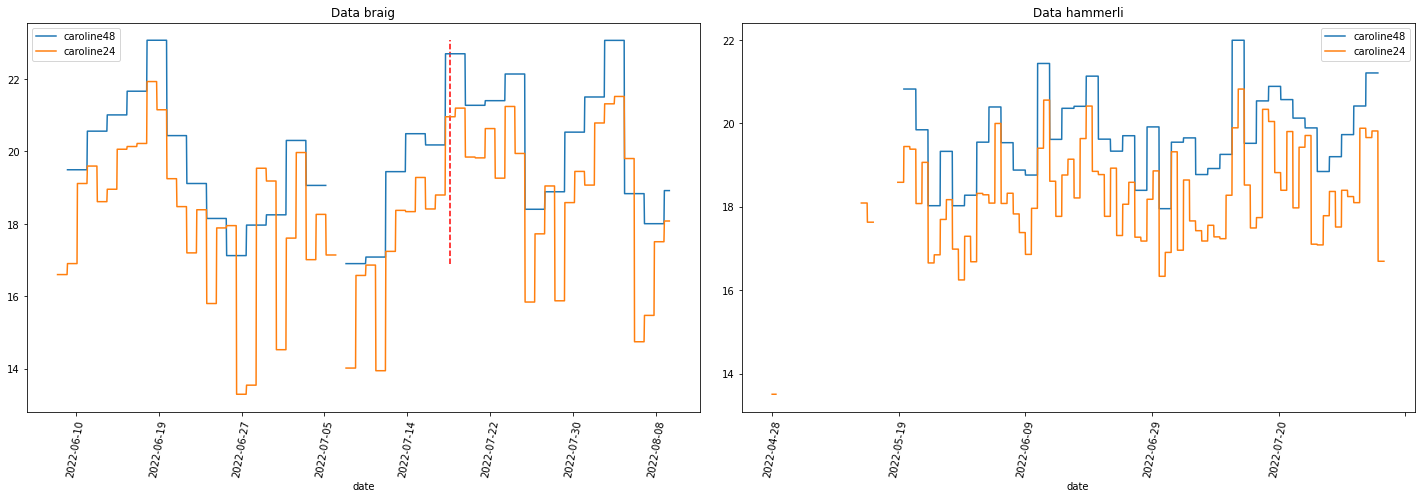

In [272]:
# calculate the equation
from math import nan


def caroline_model(df):
    """
    Simple model doing only equations per 24h and 48h.

    For 24h:
    Prediction of infection = −11.5 + 0.28 * 𝑅𝐻80 + 0.34𝑑𝑇 
    (𝑅𝐻80: hours when RH > 80% over 24h period; 𝑑𝑇: day temperature.)

    For 48h:
    Prediction of infection = −9.7 + 0.13 * 𝑅𝐻80 + 0.34𝑑𝑇 
    """
    df['caroline24'] = nan  # add a column for our results

    total_dt = 0.0  # avg temp of the day
    rh80 = 0  # hours when humidity > 80%
    n = 0  # n of hours (normally 24)
    d = 0  # d = 2 when 48h
    total_dt_48 = 0.0  # avg temp of the day
    rh80_48 = 0  # hours when humidity > 80%
    n_48 = 0  # n of hours (normally 24)

    for i, row in df.iterrows():

        date = row['date']

        if row['air_temp_celsius_avg']:
            if date[11:13] not in ["22", "23", "00", "01", "02", "03", "04", "05"]:
                n += 1
                n_48 += 1
                total_dt += row['air_temp_celsius_avg']
                total_dt_48 += row['air_temp_celsius_avg']
        rh80 += row['percent_humidity_avg'] > 80
        rh80_48 += row['percent_humidity_avg'] > 80

        # if end of the day
        if date.endswith('23:00:00+00:00') or date.endswith('23:00'):
            d += 1

            df.at[i, 'caroline24'] = -11.5 + 0.29 * \
                rh80 + 0.34 + (total_dt / n)  # equation

            df.loc[df['date'].str.startswith(date.split(' ')[0]), [
                'caroline24']] = df.at[i, 'caroline24']  # update all rows of the day

            if d == 2:  # 48h
                df.at[i, 'caroline48'] = -9.7 + 0.13 * \
                    rh80_48 + 0.34 + total_dt_48 / n_48  # equation
                df.loc[df['date'].str.startswith(date.split(' ')[0]), [
                    'caroline48']] = df.at[i, 'caroline48']  # update all rows of the day
                df.loc[df['date'].str.startswith(date_yesterday.split(' ')[0]), [
                    'caroline48']] = df.at[i, 'caroline48']  # update all rows of the day

                # prepare next day
                d = 0
                n_48 = 0
                total_dt_48 = 0
                rh80_48 = 0

            # prepare next day
            n = 0
            total_dt = 0
            rh80 = 0

            date_yesterday = date

    # Check there is a last day not terminating with 23h
    if n > 0:
        df.at[i, 'caroline24'] = -11.5 + 0.29 * \
            rh80 + 0.34 + total_dt / n  # equation
        df.loc[df['date'].str.startswith(date.split(' ')[0]), [
            'caroline24']] = df.at[i, 'caroline24']  # update all rows of the day

        df.at[i, 'caroline48'] = -9.7 + 0.13 * \
            rh80_48 + 0.34 + total_dt_48 / n_48  # equation
        df.loc[df['date'].str.startswith(date.split(' ')[0]), [
            'caroline48']] = df.at[i, 'caroline48']  # update all rows of the day
        if math.isnan(df.at[i - 24, 'caroline48']):
            df.loc[df['date'].str.startswith(date_yesterday.split(' ')[0]), [
                'caroline48']] = df.at[i, 'caroline48']  # update all rows of the day
        

    

for df in dfs:
    caroline_model(df)  # call model for each data

# Plot Caroline
plot_dfs(dfs, x="date", y=["caroline48","caroline24"])


## LWD forecast model

Dans ce modèle, pour les périodes d'infection, la prédiction est positive lorsque le produit de la durée de mouillage des feuilles (LeafWetnessDuration/LWD, heure) et de la température horaire correspondante lorsque les feuilles sont mouillées (TempLWD/TLWD, ◦C), est supérieur à 40 h*◦C (équation (1)), avec une gamme de TLWD [5,30 ◦C] et des conditions LWD supérieures à 2h.

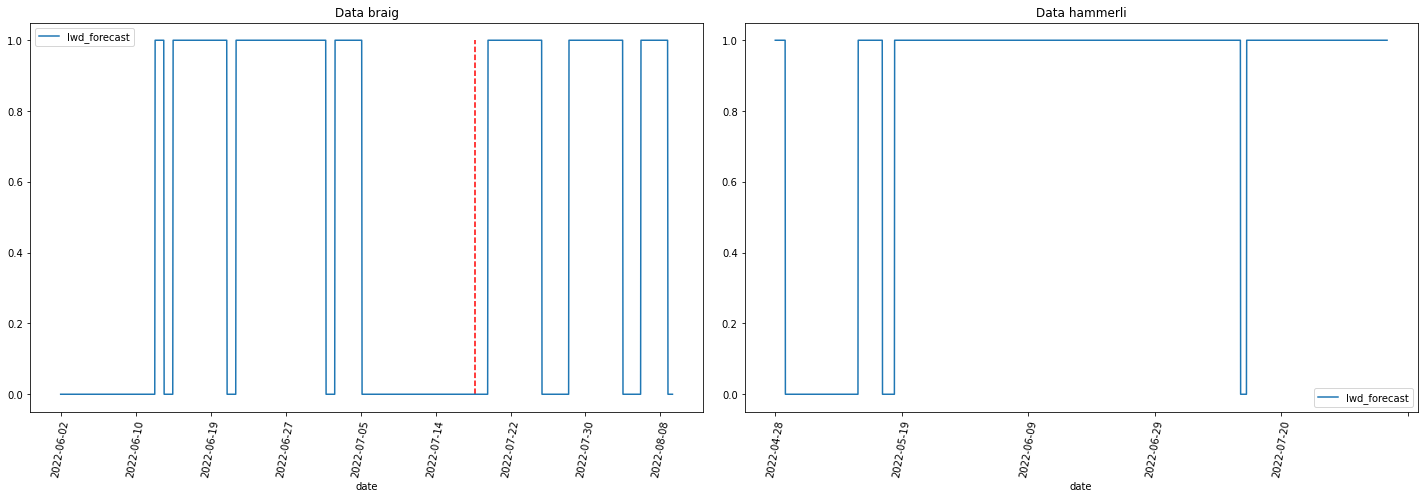

In [273]:
# calculate the equation
def lwd_forecast_model(df):
    """
    Modèle indiquant de manière binaire si une infection est prédite.

    Possibilité de rajouté une deuxième équation pour la période d'incubation.
    """

    df['lwd_forecast'] = 0  # add a column for our results
    # df = df.dropna(subset=['date'])
    # if df["date"].isna().sum() > 0:
    #     print("heo")
    #     return 


    total_dt = 0.0  # avg temp of the day
    rh80 = 0  # hours when humidity > 80% --> LW hard to use becaus doesn't change a lot
    n = 0  # n of hours (normally 24)

    for i, row in df.iterrows():

        if row['air_temp_celsius_avg'] and row['percent_humidity_avg'] > 90:
            n += 1
            total_dt += row['air_temp_celsius_avg']
        rh80 += row['percent_humidity_avg'] > 90


        date = row['date']
        # if end of the day
        if date.endswith('23:00:00+00:00') or date.endswith('23:00'):
            if rh80 > 2:
                df.at[i, 'lwd_forecast'] = int((total_dt * rh80) > 40)
                
                df.loc[df['date'].str.startswith(date.split(' ')[0]), [
                    'lwd_forecast']] = df.at[i, 'lwd_forecast']  # update all rows of the day

            # prepare next day
            n = 0
            total_dt = 0
            rh80 = 0

    # Check there is a last day not terminating with 23h
    if n != 0 and rh80 > 2:
        df.at[i, 'lwd_forecast'] = int((total_dt * rh80) > 40)

        df.loc[df['date'].str.startswith(date.split(' ')[0]), [
            'lwd_forecast']] = df.at[i, 'lwd_forecast']  # update all rows of the day


for df in dfs:
    lwd_forecast_model(df)  # call model for each data

# Plot lwd_forecast
plot_dfs(dfs, x="date", y="lwd_forecast")


## Downy mildew on roses

Un modèle de régression logistique contenait trois variables : **(i) le nombre cumulé sur 10 jours d'heures d'humidité de la feuille lorsque les températures étaient inférieures à 20°C (x)** ; **(ii) le nombre cumulé sur 10 jours d'heures de températures comprises entre 15 et 20°C (y)**, **(iii) et le nombre cumulé sur 10 jours d'heures de températures supérieures à 30°C (z)**. Dans le modèle 1, la probabilité prédite d'apparition de nouvelles infections un jour donné est donnée par la formule suivante.

- **roses_regression:** PROB = 1/[1 + exp(–23.84 – 0.45x + 1.53y+ 1.79z)]

Deux modèles polynomiaux du second ordre ont également été imaginé, ceux-ci sont plus simple à mettre en place (par jour) mais donne une précision moins bonnes. Un de ces modèles est à neuf paramètres avec tous les termes d'interaction possibles :

- **roses_polynomial_9:** INF = 1.24 – 0.42T – 1.09w + 0.27T × w + 0.015T2 + 0.041w2 – 0.0083T × w2 – 0.0078T2 ×w + 0.00023 T2 ×w2

Et également un modèle à cinq paramètres sans la combinaison des paramètres :

- **roses_polynomial_5:** INF =  –7.98  +  0.97T  +  0.74w  –  0.027T2  –  0.019w2

**w: hours of leaf wetness // T: average daily temperature**

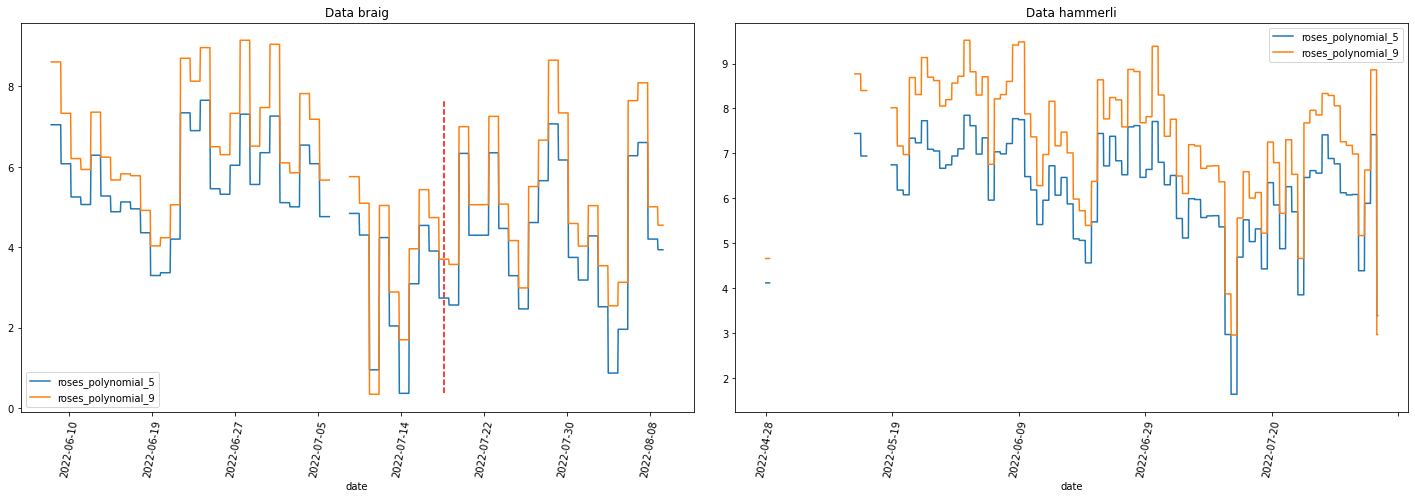

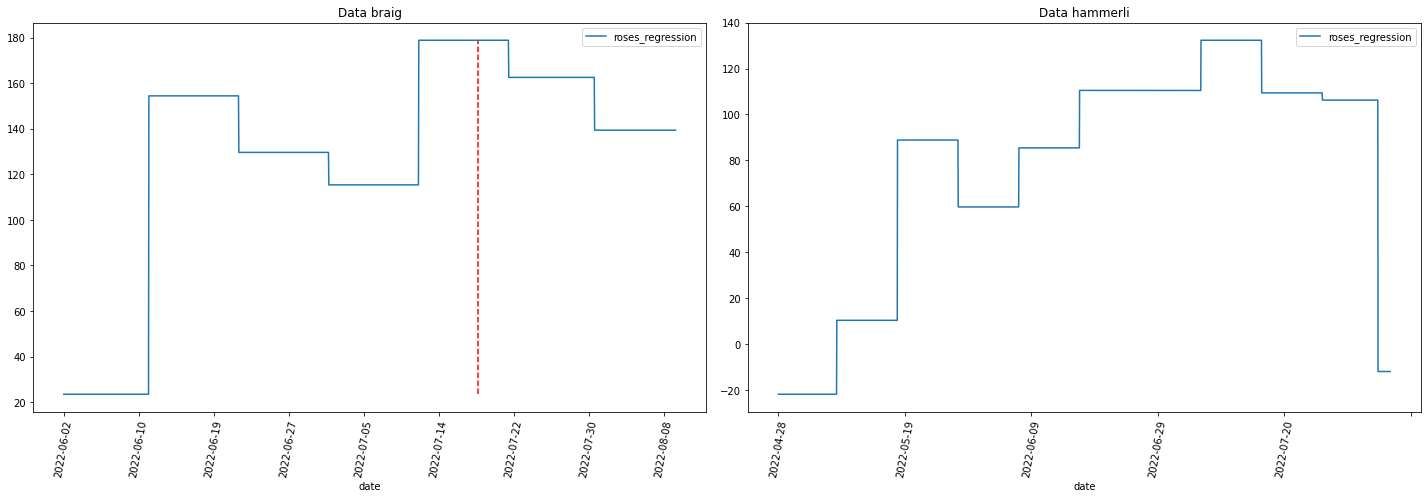

In [274]:
# calculate the equation
def roses_polynomial_models(df):
    """
    Model where we will do 2 polynomial
    equations, one with 5 parameters and 
    one with 9. We use the air relative humidity 
    and the temperature.
    """

    df['roses_polynomial_9'] = 0.0  # add a column for our results
    df['roses_polynomial_5'] = 0.0  # add a column for our results

    total_dt = 0.0  # avg temp of the day
    rh80 = 0  # hours when humidity > 80% --> LeafWetness hard to use because doesn't change a lot
    n = 0  # n of hours (normally 24)

    for i, row in df.iterrows():

        if row['air_temp_celsius_avg']:
            n += 1
            total_dt += row['air_temp_celsius_avg']
        rh80 += row['percent_humidity_avg'] > 80

        date = row['date']
        # if end of the day
        if date.endswith('23:00:00+00:00') or date.endswith('23:00'):
            T = total_dt/n
            w = rh80

            df.at[i, 'roses_polynomial_9'] = 1.24 - 0.42*T - 1.09*w + 0.27*T * w + 0.015 * pow(T, 2) + \
                0.041 * pow(w, 2) - 0.0083 * T * pow(w, 2) - 0.0078 * \
                pow(T, 2) * w + 0.00023 * pow(T, 2) * pow(w, 2)
            df.loc[df['date'].str.startswith(date.split(' ')[0]), [
                'roses_polynomial_9']] = df.at[i, 'roses_polynomial_9']  # update all rows of the day

            df.at[i, 'roses_polynomial_5'] = -7.98 + 0.97 * \
                T + 0.74 * w - 0.027 * pow(T, 2) - 0.019 * pow(w, 2)
            df.loc[df['date'].str.startswith(date.split(' ')[0]), [
                'roses_polynomial_5']] = df.at[i, 'roses_polynomial_5']  # update all rows of the day

            # prepare next day
            n = 0
            total_dt = 0
            rh80 = 0

    # Check there is a last day not terminating with 23h
    if n != 0:
        T = total_dt/n
        w = rh80

        df.at[i, 'roses_polynomial_9'] = 1.24 - 0.42*T - 1.09*w + 0.27*T * w + 0.015 * pow(T, 2) + \
            0.041 * pow(w, 2) - 0.0083 * T * pow(w, 2) - 0.0078 * \
            pow(T, 2) * w + 0.00023 * pow(T, 2) * pow(w, 2)
        df.loc[df['date'].str.startswith(date.split(' ')[0]), [
            'roses_polynomial_9']] = df.at[i, 'roses_polynomial_9']  # update all rows of the day

        df.at[i, 'roses_polynomial_5'] = -7.98 + 0.97 * \
            T + 0.74 * w - 0.027 * pow(T, 2) - 0.019 * pow(w, 2)
        df.loc[df['date'].str.startswith(date.split(' ')[0]), [
            'roses_polynomial_5']] = df.at[i, 'roses_polynomial_5']  # update all rows of the day


def roses_regression_model(df):
    """
    This time we use the logistical regression
    model that we found. We need temperature and 
    air relative humidity.
    """

    df['roses_regression'] = math.nan  # add a column for our results

    x = 0  # |
    y = 0  # v
    z = 0  # equation variables

    d = 0  # number of days

    for i, row in df.iterrows():

        if row['percent_humidity_avg'] > 80:
            if row['air_temp_celsius_avg'] < 20:
                x += 1
        if row['air_temp_celsius_avg'] > 15 and row['air_temp_celsius_avg'] < 20:
            y += 1
        if row['air_temp_celsius_avg'] > 30:
            z += 1

        date = row['date']
        # if end of the day
        if date.endswith('23:00:00+00:00') or date.endswith('23:00'):
            d += 1

            if d == 10:

                df.at[i, 'roses_regression'] = -23.84 - 0.45 * x + 1.53 * y + 1.79 * z
                df.loc[i-d*24:i]["roses_regression"] = df.at[i, 'roses_regression']

                x = 0
                y = 0
                z = 0
                d = 0

    # Check there is a last day not terminating with 23h
    if d != 0:
        df.at[i, 'roses_regression'] = -23.84 - 0.45 * x + 1.53 * y + 1.79 * z
        df.loc[i-(d+1)*24:i]["roses_regression"] = df.at[i, 'roses_regression']


for df in dfs:
    roses_polynomial_models(df)  # call model for each data
    roses_regression_model(df)  # call model for each data

# Plot lwd_forecast
plot_dfs(dfs, x="date", y=["roses_polynomial_5", "roses_polynomial_9"])
plot_dfs(dfs, x="date", y="roses_regression")


### Save the models

In [275]:
# For each station, save data and show their models
for i in range(len(dfs)):
    # Write data
    dfs[i].to_csv("out/res_"+stations[i]+".csv")

## Conclusion
We start to do a subplot to consult all the result in the same windows and correlate them.

To resume we have 6 models: caroline with 24h, caroline with 48h, lwd_forecast with a binary prediction of infection, roses polynomial with 5 parameters, roses polynomial with 9 parameters and roses logistical regression.

For Braig's data we added a red line on the 18th July because mildew was detected at this period on their cucumber culture. We can see that few models (carolines and roses regression) look like they could detect the apparition of it but only slightly.

The caroline and roses regression could work for us, but the roses polynomial and the lwd_forecast doesn't look great. Probably because the leaf sensor was not giving us good value so we had to use the air moisture.

To verify these models, we would need more information about the mildew presence and more data. If we have that we could do some machine learning to have the best model adapted for each culture.

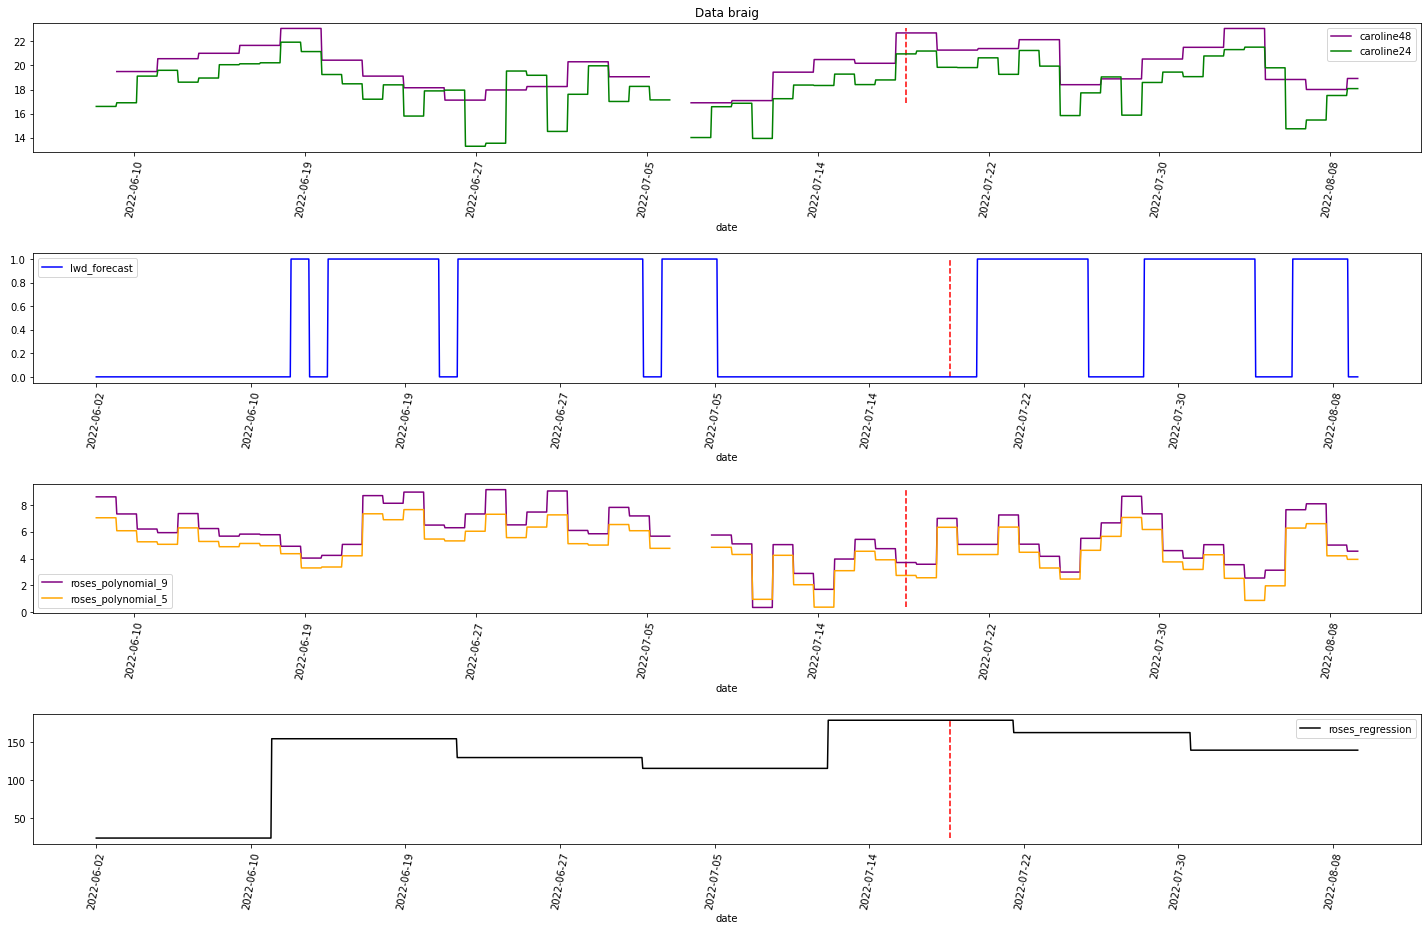

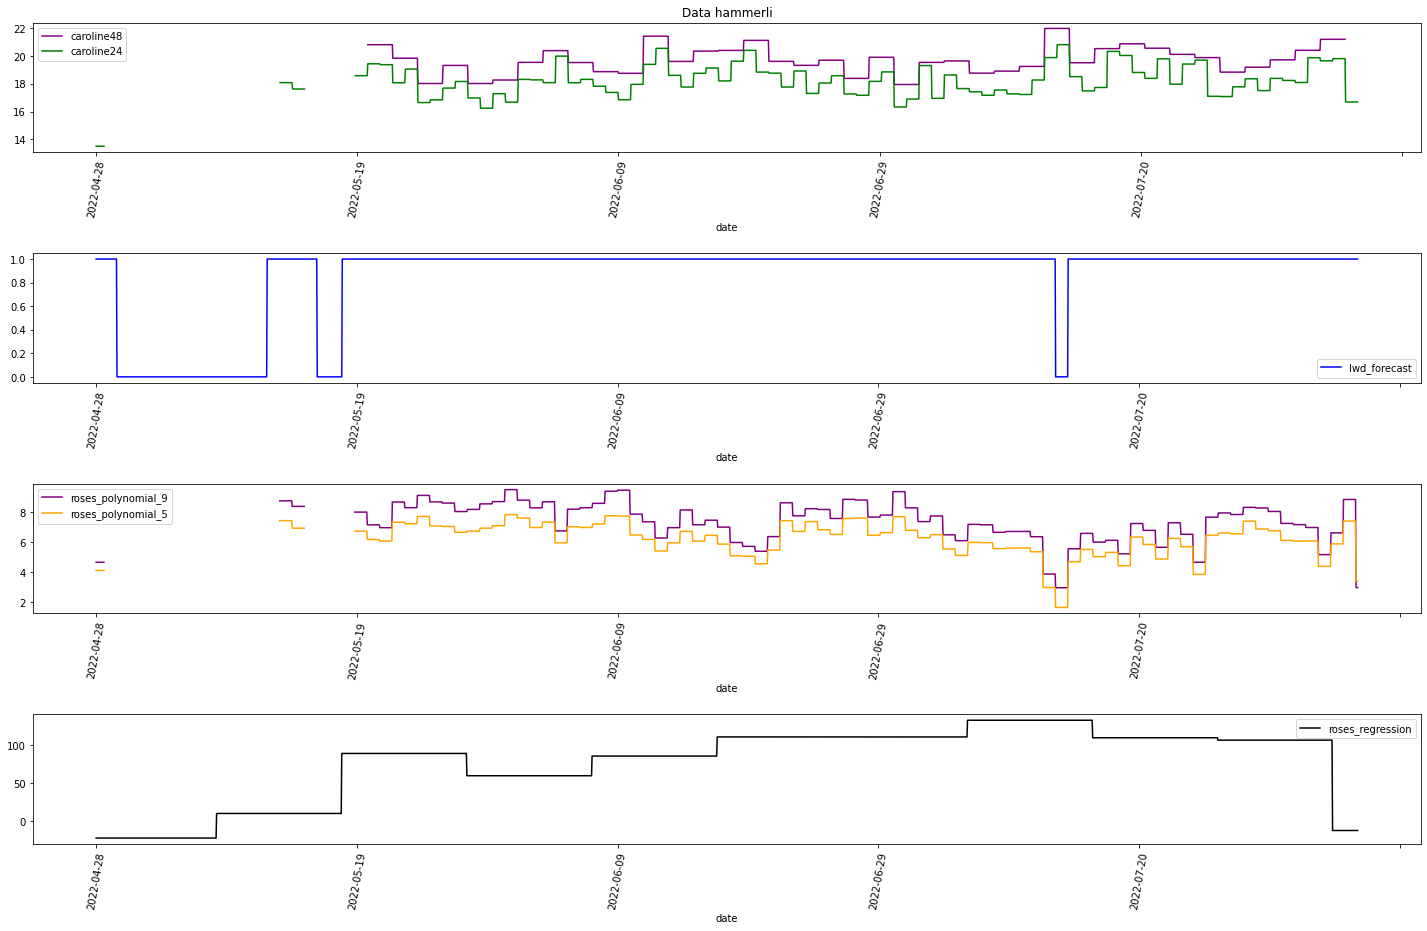

In [276]:

plt.rcParams['figure.figsize'] = [20, 12]
# For each station, save data and show their models
for i in range(len(dfs)):
    # Display models
    plot_df(dfs[i], station=stations[i], y=[["caroline48", "caroline24"], ["lwd_forecast"], ["roses_polynomial_9","roses_polynomial_5"], ["roses_regression"]])